# Crime vs Population

Dataset: https://www.kaggle.com/marshallproject/crime-rates

The goal in this notebook is to present how does a linear regression model actually works. For this purpouse I will not use any machine learning. This exercise is inspired by the Andrew Ng course of Machine Learning.

The usecase is to see if there is a correlation between crime vs population. 

## Setup

In [288]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib notebook

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
warnings.filterwarnings(action="ignore", module="sklearn", message="^Objective did not")

import locale
locale.setlocale(locale.LC_NUMERIC, '')
pd.options.display.float_format = '{:0,.02f}'.format
np.set_printoptions(suppress=True)

## Load Data

In [809]:
all_data = pd.read_csv('data/report.csv')
print(all_data.shape)
print(all_data.describe())

(2829, 15)
       report_year     population  violent_crimes   homicides      rapes  \
count   2,829.0000     2,760.0000      2,794.0000  2,795.0000 2,754.0000   
mean    1,995.0000   795,698.0891     29,632.5451    398.3853   416.2789   
std        11.8343 1,012,450.5696    172,863.0236  2,281.2764   479.8119   
min     1,975.0000   100,763.0000        154.0000      1.0000    15.0000   
25%     1,985.0000   377,931.0000      3,014.7500     32.0000   176.2500   
50%     1,995.0000   536,614.5000      5,135.5000     64.0000   291.0000   
75%     2,005.0000   816,855.7500      9,058.5000    131.0000   465.0000   
max     2,015.0000 8,550,861.0000  1,932,274.0000 24,703.0000 3,899.0000   

         assaults    robberies  months_reported  crimes_percapita  \
count  2,753.0000   2,754.0000       2,692.0000        2,794.0000   
mean   4,405.1460   4,000.2451          11.8689        1,093.0498   
std    6,977.2938   8,653.9030           1.1182          676.8847   
min       15.0000      83.00

In [1002]:
all_data[all_data.report_year == 2014][:5]

,report_year,agency_code,agency_jurisdiction,population,violent_crimes,homicides,rapes,assaults,robberies,months_reported,crimes_percapita,homicides_percapita,rapes_percapita,assaults_percapita,robberies_percapita
2691,2014,NM00101,"Albuquerque, NM","558,874.0000","4,934.0000",30.0000,402.0000,"3,121.0000","1,381.0000",12.0000,882.8500,5.3700,71.9300,558.4400,247.1000
2692,2014,TX22001,"Arlington, TX","382,976.0000","1,854.0000",13.0000,206.0000,"1,142.0000",493.0000,12.0000,484.1000,3.3900,53.7900,298.1900,128.7300
2693,2014,GAAPD00,"Atlanta, GA","454,363.0000","5,577.0000",93.0000,151.0000,"3,004.0000","2,329.0000",12.0000,"1,227.4300",20.4700,33.2300,661.1500,512.5900
2694,2014,CO00101,"Aurora, CO","350,948.0000","1,430.0000",9.0000,273.0000,734.0000,414.0000,12.0000,407.4700,2.5600,77.7900,209.1500,117.9700
2695,2014,TX22701,"Austin, TX","903,924.0000","3,581.0000",32.0000,571.0000,"2,105.0000",873.0000,12.0000,396.1600,3.5400,63.1700,232.8700,96.5800


I'll simplify my task for now and use the latest year to build my model

In [1030]:
# latest_report = all_data[all_data.report_year > 2000]
latest_report = latest_report[pd.notnull(latest_report['population'])]
latest_report = latest_report[pd.notnull(latest_report['violent_crimes'])]

X = latest_report[['population']]
X = X/100
X = (X - X.mean())/X.std()
X.insert(0, 'ones', 1)
X = X.as_matrix()

y = latest_report[['violent_crimes']]
m = len(y)

## Visualize Data

In [1031]:
def plot_scatter_line(X, y, theta, title='', xlabel='', ylabel=''):
    X = X[:, 1]
    interval = np.linspace(X.min(), X.max())
    result = interval * theta[1] + theta[0]

    plt.figure()
    plt.plot(interval, result, '-r')
    plt.scatter(X, y, marker='x')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

def plot_learning_curve(cost_history):
    plt.figure()
    plt.title('Learning curve')
    plt.xlabel('Iterations')
    plt.ylabel('J(theta)')
    plt.plot(cost_history)

A naive way to solve this problem is to get the mean value:

<IPython.core.display.Javascript object>


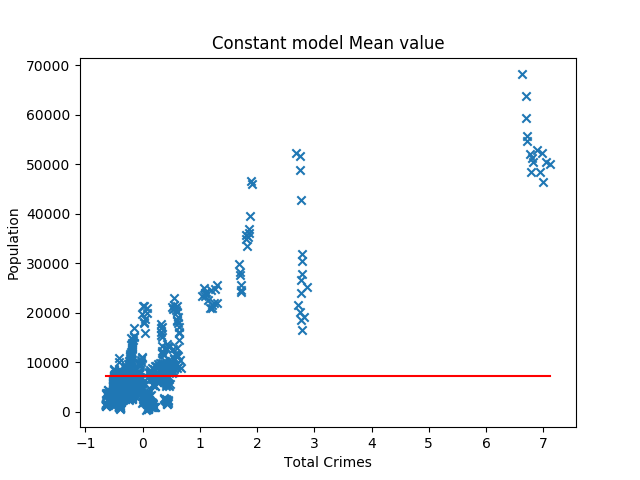

In [1032]:
plot_scatter_line(X, y, np.array([[y.mean()], [0]]), title='Constant model Mean value', xlabel='Total Crimes', ylabel='Population')

## Cost function

We mesure the difference of our hypothesis and the actual $y$ using the cost function $J$ that takes the parameter vector $\theta$ as argument. The definition of $J$ is the following:

$J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2$

where $h_{\theta}(x) = \theta^Tx = \theta_0x_0 + \theta_1x_1 $ and $x_0 = 1$. In our usecase $\theta_0$ is something like base minimal number of crimes for any population (it is called intercept parameter). The forumla for $J$ is basically the average squared distance between prediction and expected values devided by two so that we get convergance when we get the derivative - more on that latter.

In [1033]:
def get_cost(X, y, theta):
    m = len(y)
    h_theta = np.dot(X, theta)
    squared_dist = np.power(h_theta - y.values, 2)
    
    return np.sum(squared_dist)/(2*m)

## Finding parameters using gradient descent

Our goal is to minimize $J(\theta)$, therefore we need to find $\theta$ that gives the (hopefuly) the global minimum of $J$.
One way to do so is to take small steps (with length $\alpha$) in direction of the steepest descent. That means we should find the partial derivatives of $J$ with respect of each individual parameter.
The partial derivatives are (assuming $x_0 = 1$):

$\frac{\partial J}{\partial \theta} = \frac{1}{m} \sum_{i=0}^{m} (h_\theta(x^{(i)}) - y^{(i)})x^{(i)}$

The way that we take steps is the following:

$\theta_j := \theta_j - \alpha \frac{\partial J}{\partial \theta_j}$


In [1034]:
print(X.shape)
X[:5]

(1015, 2)


array([[ 1.        , -0.39431115],
       [ 1.        , -0.49695655],
       [ 1.        , -0.41713537],
       [ 1.        , -0.54954406],
       [ 1.        , -0.18974628]])

In [1035]:
def gradient_descent(X, y, theta, alpha, iterations):
    m = len(y)
    cost_history = []

    for i in range(iterations):
        if len(cost_history) > 2 and cost_history[i - 2] == cost_history[i-1]:
            break

        h = X.dot(theta)
        y_diff = h - y
        partials = 1/m * (np.multiply(X, y_diff).sum(axis=0))     
                
        theta = theta - alpha * partials.T
        cost_history.append(get_cost(X, y, theta))

    return theta, cost_history

In [1036]:
theta, cost_history = gradient_descent(X, y, np.matrix('0; 0'), 0.1, 100)
print(theta)

[[ 7149.75984103]
 [ 7475.83256181]]


<IPython.core.display.Javascript object>


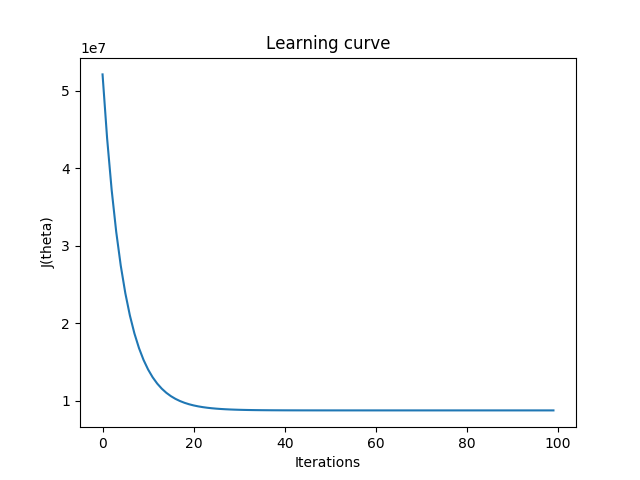

In [1037]:
plot_learning_curve(cost_history)

<IPython.core.display.Javascript object>


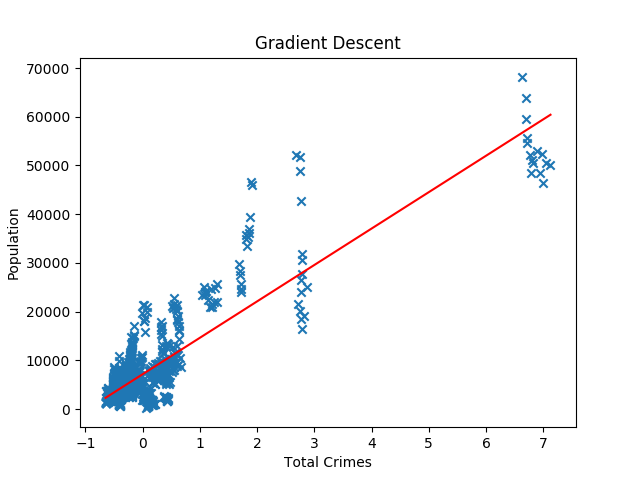

In [1038]:
plot_scatter_line(X, y, [theta.item(0), theta.item(1)], title='Gradient Descent', xlabel='Total Crimes', ylabel='Population')

Lets compare the results with the sklearn LinearRegression model:

7149.94975369 7476.0333213


<IPython.core.display.Javascript object>


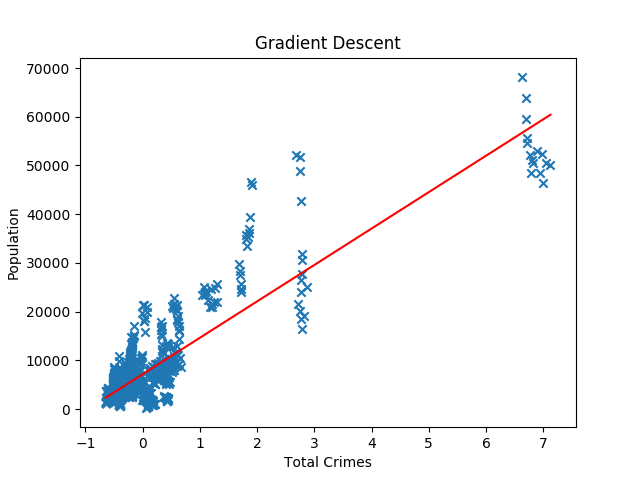

In [1039]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(X, y)
theta_0, theta_1 = model.intercept_[0], model.coef_[0][1]
print(theta_0, theta_1)
plot_scatter_line(X, y, [theta_0, theta_1], title='Gradient Descent', xlabel='Total Crimes', ylabel='Population')

## Finding parameters using normal equestions method

This is analytical method for finding the parameters. It does not need learning step. The down side is that it does not scale well. The complexity is $O^3$.

In [1040]:
theta = np.linalg.pinv(X.T.dot(X)).dot(X.T.dot(y))
theta

array([[ 7149.94975369],
       [ 7476.0333213 ]])

<IPython.core.display.Javascript object>


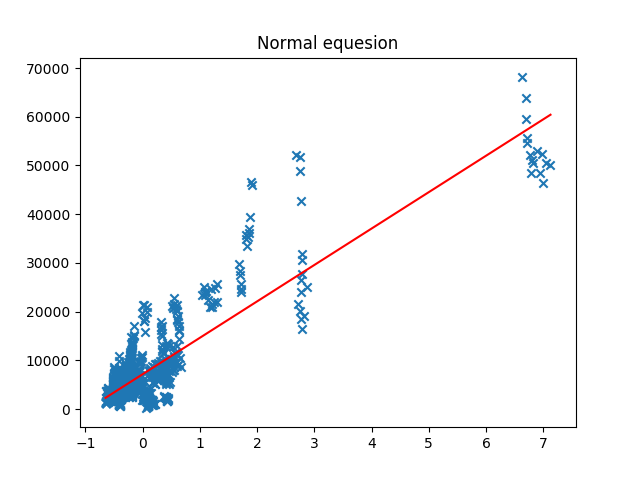

In [1041]:
plot_scatter_line(X, y, theta, 'Normal equesion')

## Population vs Profit

The same function can be used to model simular problems. For example:

In [1042]:
pd.options.display.float_format = '{:0,.04f}'.format

data = pd.read_csv('data/population_vs_profit.csv')
X = data[['population']]
y = data[['profit']]
m = y.size
data.head()

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


<IPython.core.display.Javascript object>


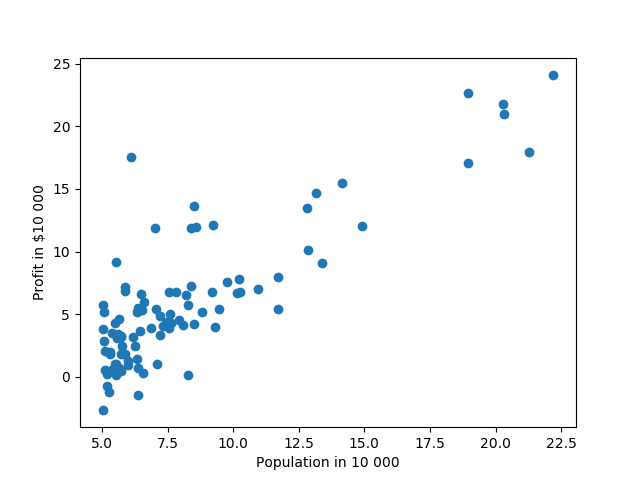

In [1043]:
plt.figure()
plt.xlabel('Population in 10 000')
plt.ylabel('Profit in $10 000')
plt.scatter(X, y)

In [1044]:
X.insert(0, 'ones', 1)
X = X.as_matrix()
theta, cost_history = gradient_descent(X, y, np.matrix('0; 0'), 0.01, 1500)
theta_0 = theta.item(0)
theta_1 = theta.item(1)

<IPython.core.display.Javascript object>


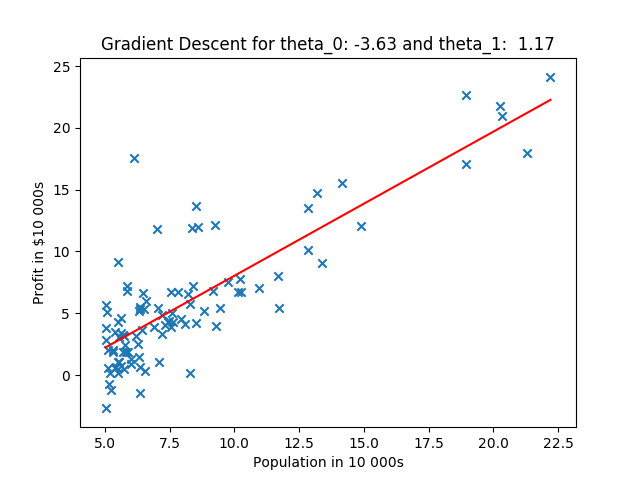

In [1045]:
plot_scatter_line(X, y, [theta_0, theta_1],
                  title='Gradient Descent for theta_0: {0: 0.02f} and theta_1: {1: 0.02f}'.format(theta_0, theta_1, '0.02f'),
                  xlabel='Population in 10 000s',
                  ylabel='Profit in $10 000s')

<IPython.core.display.Javascript object>


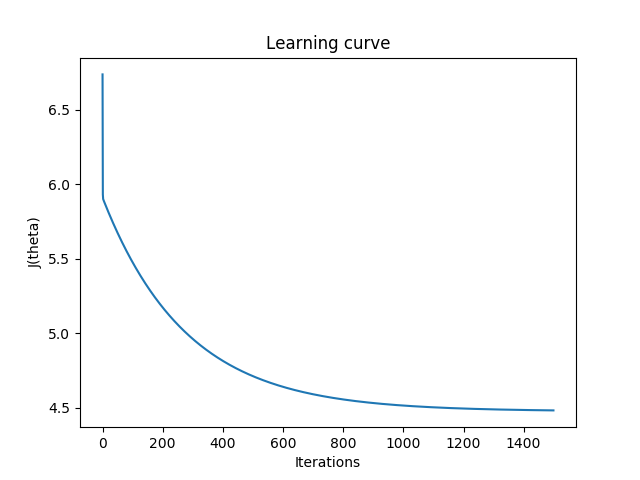

In [1046]:
plt.figure()
plt.title('Learning curve')
plt.xlabel('Iterations')
plt.ylabel('J(theta)')
plt.plot(cost_history)

In [1047]:
print(get_cost(X, y, [[-1], [2]]))
print(get_cost(X, y, [[0], [0]]))

54.242455082
32.0727338775


In [1048]:
theta_0_vals = np.linspace(-10, 10, 100)
theta_1_vals = np.linspace(-1, 4, 100)

j_vals = []

for i in theta_0_vals:
    j_i_vals = []
    for j in theta_1_vals:
        cost = get_cost(X, y, [[i], [j]])
        j_i_vals.append(cost)
    j_vals.append(j_i_vals)
    
np.matrix(j_vals)

matrix([[ 328.09290555,  316.6648683 ,  305.44447299, ...,  186.35412584,
          195.06735595,  203.98822799],
        [ 323.26504192,  311.92025945,  300.7831189 , ...,  189.60197489,
          198.39845977,  207.40258658],
        [ 318.47799046,  307.21646275,  296.16257698, ...,  192.89063611,
          201.77037576,  210.85775734],
        ..., 
        [  49.81156018,   46.45923561,   43.31455298, ...,  691.41691065,
          708.20585345,  725.20243817],
        [  48.94247627,   45.67340647,   42.61197861, ...,  698.62353943,
          715.49573699,  732.57557648],
        [  48.11420452,   44.9283895 ,   41.95021641, ...,  705.87098036,
          722.82643269,  739.98952696]])

-3.6302914394043606 1.166362350335582


<IPython.core.display.Javascript object>


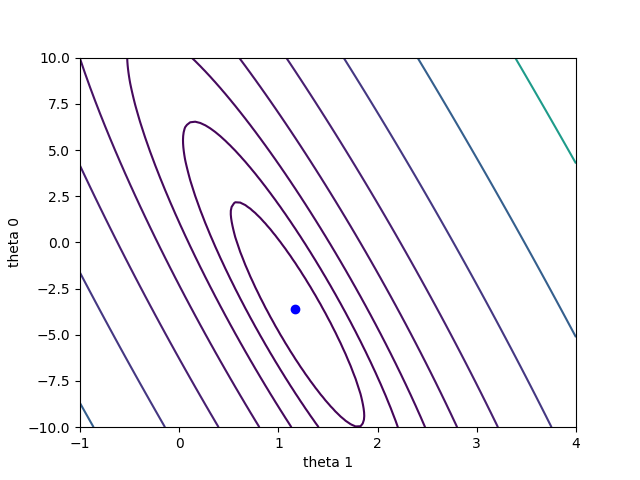

In [1049]:
print(theta_0, theta_1)
plt.figure()
plt.xlabel('theta 1')
plt.ylabel('theta 0')
plt.plot(theta_1, theta_0, 'bo')
plt.contour(theta_1_vals, theta_0_vals, j_vals, np.logspace(-2, 3, 20))
